### Python Libraries

Standard Python imports

In [1]:
import os, sys, time, glob

In [2]:
from collections import deque
from pprint import pprint

In [3]:
from math import pi, radians
deg = radians(1)    # so that we can refer to 90*deg
I = 1j              # potentially neater imaginary nomenclature.

In [4]:
import numpy as np  # Does high performance dense array operations
np.set_printoptions(edgeitems=30, linewidth=100000,
                    formatter=dict(float=lambda x: "%.3g" % x))
import scipy as sp

In [5]:
from toolz.itertoolz import (concat, partition, interleave)
from toolz.functoolz import (curry, pipe, thread_first)
# from toolz.dicttoolz import ()

In [6]:
from UtilityMath import (plotComplexArray, 
                         RandomComplexCircularMatrix, RandomComplexGaussianMatrix,
                         PolarPlot,
                         RescaleToUnitary,
                         ReIm,
                         MatrixSqError, MatrixError, MatrixErrorNormalized)

Loading BokehJS ...

In [7]:
import networkx as nx
import pylab as plt

# Work

## Clements Decomposition

In [8]:
from numpy import cos, sin, exp

In [9]:
np.set_printoptions(edgeitems=30, linewidth=100000,
                    suppress=True,
                    formatter=dict(float=lambda x: "%.2g" % x))

### Unitary Matrix Generation

In [10]:
def isPassive(M, verbose=False):
    Im = np.identity(M.shape[0])
    TH = np.conj(M.T)
    eigVals = np.linalg.eigvals(Im - TH @ M).real
    if verbose:
        print(eigVals)
    isPassive = np.alltrue(eigVals >= -1e-12)
    return isPassive

In [11]:
testM = np.identity(5, dtype='complex')
isPassive(testM)

True

In [12]:
def getRandomUnitaryMatrix(n=5, verbose=False):
    rMat = RandomComplexCircularMatrix(1, (n, n))
    # print(rMat)
    U, Svec, Vh = np.linalg.svd(rMat, full_matrices=True)
    S = np.diag(Svec)
    recovery = U @ S @ Vh
    if verbose:
        print("Successful SVD Decomposition:", np.allclose(recovery, rMat))
    M = U @ Vh
    return M

In [13]:
U = getRandomUnitaryMatrix(n=5)

### Mixer

The `Mixer` represents a 4 port directional coupler with variable weights similar to a Mach-Zender Interferometer.

We begin with the definition of a directional "beam splitter" given below
$$
T(\theta, \phi) = \begin{pmatrix}
e^{i\phi} \cos(\theta) & -\sin(\theta)\\
e^{i\phi} \sin(\theta) & \cos(\theta)
\end{pmatrix}
$$
This shows only the transmissive part and all reflections are assumed to be zero.

In [14]:
def T(theta, phi):
    a = [[ exp(I*phi) * cos(theta), -sin(theta)], 
         [ exp(I*phi) * sin(theta),  cos(theta)]]
    return np.array(a)

We also need the inverse of this matrix.  This was computed in Mathematica.

In [15]:
def Tinv(theta, phi):
    a = [[ exp(-I*phi) * cos(theta),  exp(-I*phi) * sin(theta)],
         [              -sin(theta),                cos(theta)]]
    return np.array(a)

This allows us to define a simple class for a `Mixer`.

In [16]:
class Mixer:

    def __init__(self, theta_phi=(0,0)):
        self.theta, self.phi = theta_phi

    def T(self):
        return T(self.theta, self.phi)

    def Tinv(self):
        return Tinv(self.theta, self.phi)

In [17]:
mixer = Mixer()
mixer = Mixer(theta_phi=(0.2*pi, 0.3*pi))

In [18]:
print(mixer.T())
print(mixer.Tinv())

[[ 0.47552826+0.6545085j  -0.58778525+0.j        ]
 [ 0.3454915 +0.47552826j  0.80901699+0.j        ]]
[[ 0.47552826-0.6545085j   0.3454915 -0.47552826j]
 [-0.58778525+0.j          0.80901699+0.j        ]]


### Mixer Mesh Interaction

The formulation makes use of how a mixer interacts with all of the channels in the system.  Let us imagine a vector of $n$ 
 lines.  Of course, if the mixer is not connected to a line, that line would remain unperturbed.  It follows that we can understand a mixer's effect on a
mesh as the identity matrix with several elements changed to those given by $T(\theta, \phi)$ above.

Note that within the paper, Clements uses the notation $T_{m,n}(\theta, \phi)$ which represents a mixing between lines $m$ and $n$.  In all cases within
that work, $n = m + 1$.

In [19]:
def TMesh(theta_phi, N, lines):
    A = np.identity(N, dtype='complex')
    a = T(*theta_phi)
    m, n = lines
    A[m, m] = a[0,0]
    A[m, n] = a[0,1]
    A[n, m] = a[1,0]
    A[n, n] = a[1,1]
    return A

In [20]:
def TinvMesh(theta_phi, N, lines):
    A = np.identity(N, dtype='complex')
    a = Tinv(*theta_phi)
    m, n = lines
    A[m, m] = a[0,0]
    A[m, n] = a[0,1]
    A[n, m] = a[1,0]
    A[n, n] = a[1,1]
    return A

In [21]:
mixer = Mixer(theta_phi=(0.2*pi, 0.3*pi))
print(mixer.T())
print(mixer.Tinv())

[[ 0.47552826+0.6545085j  -0.58778525+0.j        ]
 [ 0.3454915 +0.47552826j  0.80901699+0.j        ]]
[[ 0.47552826-0.6545085j   0.3454915 -0.47552826j]
 [-0.58778525+0.j          0.80901699+0.j        ]]


In [22]:
TMesh(theta_phi=(0.3*pi, 0.2*pi), N=5, lines=(1,2))

array([[ 1.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.47552826+0.3454915j , -0.80901699+0.j        ,  0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.6545085 +0.47552826j,  0.58778525+0.j        ,  0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  1.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  1.        +0.j        ]])

In [23]:
TinvMesh(theta_phi=(0.3*pi, 0.2*pi), N=5, lines=(1,2))

array([[ 1.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.47552826-0.3454915j ,  0.6545085 -0.47552826j,  0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        , -0.80901699+0.j        ,  0.58778525+0.j        ,  0.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  1.        +0.j        ,  0.        +0.j        ],
       [ 0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  0.        +0.j        ,  1.        +0.j        ]])

And just as a check, let us verify that the analytical aligns with the numerical inverse.

In [24]:
invNum = np.linalg.inv(TMesh(theta_phi=(0.4*pi, 0.2*pi), N=5, lines=(1,4)))
invAnal = TinvMesh(theta_phi=(0.4*pi, 0.2*pi), N=5, lines=(1,4))
np.allclose(invNum, invAnal)

True

### Mesh

In [25]:
def EvenQ(n):
    """
    True if n is even.
    False otherwise.
    """
    return(n%2==0)

def OddQ(n):
    """
    True if n is odd.
    False otherwise.
    """    
    return(n%2==1)  

Computes the number of layers in the mesh required to obtain `totCount` number of mixers.  For instance, suppose that you want 6 DoFs from a 4 port to 4 port mesh.  The even columns (0th, 2nd, etc) would have 2 mixers.  The odd columns (1st, 3rd, etc) would have 1 mixer.

In [26]:
def computeNLayers(evenCount, oddCount, totCount):
    """
    Given finds the total number of elements in the pattern [e, o, e, o, ...]
    required to achieve `totCount`.  Returns `None` if not evenly divisable.

    This is done directly by totaling the contribution of an e + o combination
    """
    if totCount == 1:
        return 1
    comboCount = evenCount + oddCount
    nComboLayers = totCount//comboCount
    if nComboLayers*comboCount == totCount:
        return 2*nComboLayers
    elif nComboLayers*comboCount + evenCount == totCount:
        return 2*nComboLayers + 1
    else:
        print("does not appear evenly divisable")
        return None


In [27]:
4 == computeNLayers(evenCount=2, oddCount=1, totCount=6) # 2 + 1 + 2 + 1

True

In [28]:
3 == computeNLayers(evenCount=2, oddCount=5, totCount=9) # 2 + 5 + 2

True

In [29]:
# None == computeNLayers(evenCount=2, oddCount=5, totCount=8) # 2 + 5 + ?

Generates Device Labels for mesh which can realize a given kernel size.
It will return labels for each input port, output port, mixer, and thru.  Only the mixers
are used for mesh calcu

This is done in a naive fashion, stepping across the mesh from the input ports to
the output ports.  For lines which do not intersect a mixer, a thru will be inserted. 

In [30]:
def generateDeviceLabels(kernelSize, mixerLabel='m', thruLabel='t', inputLabel='i', outputLabel='o', verbose=False):
    NN = kernelSize
    evenCount = NN//2
    oddCount = (NN-1)//2
    if verbose: print("NN:", NN)
    nMixers = NN*(NN-1)//2
    if verbose: print("nDOFs:", nMixers)
    if verbose: print("evenCounts:", evenCount, "\toddCounts:", oddCount)
    nLayers = computeNLayers(evenCount, oddCount, nMixers)
    if verbose: print("nLayers:", nLayers)
    mixers = []
    thrus = []
    inPorts = [(inputLabel, i) for i in range(kernelSize)]
    if verbose: print("inPorts:", inPorts)    
    outPorts = [(outputLabel, i) for i in range(kernelSize)]
    if verbose: print("outPorts:", outPorts)    
    (i, j) = (0, 0)
    while i < nLayers:
        oddLayer = (i%2 == 1)
        if (j == 0 and oddLayer) or (j == NN - 1):
            thrus.append((thruLabel, i, j))
            j += 1
        else:
            mixers.append((mixerLabel, i, j))
            j += 2
        if j >= NN:
            j = 0
            i += 1
    if verbose: print("mixers:", mixers)
    if verbose: print("thrus:", thrus)
    return (inPorts, mixers, thrus, outPorts)

In [31]:
(inPorts, mixers, thrus, outPorts) = generateDeviceLabels(kernelSize=5, mixerLabel='m', thruLabel='t', verbose=True)

NN: 5
nDOFs: 10
evenCounts: 2 	oddCounts: 2
nLayers: 5
inPorts: [('i', 0), ('i', 1), ('i', 2), ('i', 3), ('i', 4)]
outPorts: [('o', 0), ('o', 1), ('o', 2), ('o', 3), ('o', 4)]
mixers: [('m', 0, 0), ('m', 0, 2), ('m', 1, 1), ('m', 1, 3), ('m', 2, 0), ('m', 2, 2), ('m', 3, 1), ('m', 3, 3), ('m', 4, 0), ('m', 4, 2)]
thrus: [('t', 0, 4), ('t', 1, 0), ('t', 2, 4), ('t', 3, 0), ('t', 4, 4)]


Generates Mixer Labels for a mesh which can realize a given kernel size.

This is done in a naive fashion, stepping across the mesh from the input ports
to the output ports.  Mixers are grouped by column.  In other words, all mixers
which touch the input ports are in the first list.

In [32]:
def generateMixerLabels(kernelSize, mixerLabel='m', verbose=False):
    NN = kernelSize
    evenCount = NN//2
    oddCount = (NN-1)//2
    if verbose: print("NN:", NN)
    nMixers = NN*(NN-1)//2
    if verbose: print("nDOFs:", nMixers)
    if verbose: print("evenCounts:", evenCount, "\toddCounts:", oddCount)
    nLayers = computeNLayers(evenCount, oddCount, nMixers)
    if verbose: print("nLayers:", nLayers)
    mixers = []
    (i, j) = (0, 0)
    for i in range(nLayers):
        if EvenQ(i):
            colList = [(mixerLabel, i, 2*j) for j in range(0, evenCount)]
        if OddQ(i):
            colList = [(mixerLabel, i, 2*j + 1) for j in range(0, oddCount)]            
        mixers.append(colList)
    return (mixers)

In [33]:
generateMixerLabels(kernelSize=5, mixerLabel='m', verbose=True)

NN: 5
nDOFs: 10
evenCounts: 2 	oddCounts: 2
nLayers: 5


[[('m', 0, 0), ('m', 0, 2)],
 [('m', 1, 1), ('m', 1, 3)],
 [('m', 2, 0), ('m', 2, 2)],
 [('m', 3, 1), ('m', 3, 3)],
 [('m', 4, 0), ('m', 4, 2)]]

Generates Mixer Labels for a mesh which can realize a given kernel size.

This is done on the diagonal to create a list which corresponds to the order in
which they are nulled according to Clements et al.  Mixers are grouped by diagonal.

In [34]:
def generateMixerLabelsDiag(kernelSize, mixerLabel='m', verbose=False):
    NN = kernelSize
    orderedLabels = []
    for i in range(NN-1):
        diagList = []
        for j in range(i+1):
            if EvenQ(i):
                label = (mixerLabel, j, i - j)
            else:
                label = (mixerLabel, NN - j - 1, NN - (i - j) - 2)
            diagList.append(label)
        orderedLabels.append(diagList)
    return orderedLabels

In [35]:
generateMixerLabelsDiag(kernelSize=5, mixerLabel='m', verbose=False)

[[('m', 0, 0)],
 [('m', 4, 2), ('m', 3, 3)],
 [('m', 0, 2), ('m', 1, 1), ('m', 2, 0)],
 [('m', 4, 0), ('m', 3, 1), ('m', 2, 2), ('m', 1, 3)]]

We now have three ways of generating mixer labels.  Let's confirm they all give the same results.

In [36]:
NN = 100
(inPorts, mixers, thrus, outPorts) = generateDeviceLabels(kernelSize=NN, mixerLabel='m', thruLabel='t', verbose=False)
s1 = mixers
s2 = list(concat(generateMixerLabels(kernelSize=NN, mixerLabel='m', verbose=False)))
s3 = list(concat(generateMixerLabelsDiag(kernelSize=NN, mixerLabel='m', verbose=False)))

In [37]:
sorted(s1) == sorted(s2) and sorted(s1) == sorted(s3)


True

### Drawing

In [38]:
(inPortLabels, mixerLabels, thruLabels, outPortLabels) = generateDeviceLabels(kernelSize=5, mixerLabel='m', thruLabel='t', verbose=True)

NN: 5
nDOFs: 10
evenCounts: 2 	oddCounts: 2
nLayers: 5
inPorts: [('i', 0), ('i', 1), ('i', 2), ('i', 3), ('i', 4)]
outPorts: [('o', 0), ('o', 1), ('o', 2), ('o', 3), ('o', 4)]
mixers: [('m', 0, 0), ('m', 0, 2), ('m', 1, 1), ('m', 1, 3), ('m', 2, 0), ('m', 2, 2), ('m', 3, 1), ('m', 3, 3), ('m', 4, 0), ('m', 4, 2)]
thrus: [('t', 0, 4), ('t', 1, 0), ('t', 2, 4), ('t', 3, 0), ('t', 4, 4)]


In [39]:
def makeGraph(inPortLabels, mixerLabels, thruLabels, outPortLabels):
    G = nx.Graph()
    maxMixerX = np.max(np.array(mixerLabels,dtype=object)[:,1])
    maxMixerY = np.max(np.array(mixerLabels,dtype=object)[:,2])
    for lab in inPortLabels:
        (_, y) = lab
        G.add_node(lab, pos=(-1, -y), col='#88ff88')
    for lab in mixerLabels:
        (_, x, y) = lab
        G.add_node(lab, pos=(x, -y-0.5), col='#ffff00')
    for lab in thruLabels:
        (_, x, y) = lab
        if y == 0:
            G.add_node(lab, pos=(x, -y-0.5), col='#8888ff')
        else:
            G.add_node(lab, pos=(x, -y+0.5), col='#8888ff')
    for lab in outPortLabels:
        (_, y) = lab
        G.add_node(lab, pos=(maxMixerX+1, -y), col='#ff8888')
    for lab in inPortLabels:
        pass
    allElements = set()
    for l in (inPortLabels, mixerLabels, thruLabels, outPortLabels):
        allElements.update(l)
    for lab in mixerLabels:
        (_, x, y) = lab
        potLab = ('m', x+1, y+1)
        if potLab in allElements:
            G.add_edge(lab, potLab)
        potLab = ('m', x+1, y-1)
        if potLab in allElements:
            G.add_edge(lab, potLab)
        potLab = ('t', x+1, y)
        if potLab in allElements:
            G.add_edge(lab, potLab)
        potLab = ('t', x+1, y+1)
        if potLab in allElements:
            G.add_edge(lab, potLab)
        potLab = ('t', x-1, y)
        if potLab in allElements:
            G.add_edge(lab, potLab)
        potLab = ('t', x-1, y+1)
        if potLab in allElements:
            G.add_edge(lab, potLab)
    for lab in inPortLabels:
        (_, y) = lab
        potLab = ('m', 0, y-1)
        if potLab in allElements:
            G.add_edge(lab, potLab)
        potLab = ('m', 0, y)
        if potLab in allElements:
            G.add_edge(lab, potLab)
        potLab = ('t', 0, y)
        if potLab in allElements:
            G.add_edge(lab, potLab)
    for lab in outPortLabels:
        (_, y) = lab
        potLab = ('m', maxMixerX, y-1)
        if potLab in allElements:
            G.add_edge(lab, potLab)
        potLab = ('m', maxMixerX, y)
        if potLab in allElements:
            G.add_edge(lab, potLab)
        potLab = ('t', maxMixerX, y)
        if potLab in allElements:
            G.add_edge(lab, potLab)
    return G                               
    

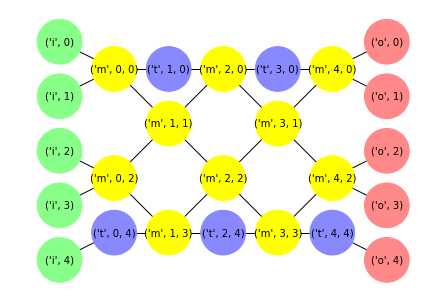

In [40]:
(inPortLabels, mixerLabels, thruLabels, outPortLabels) = generateDeviceLabels(kernelSize=5, mixerLabel='m', thruLabel='t', verbose=False)
G = makeGraph(inPortLabels, mixerLabels, thruLabels, outPortLabels)
pos = nx.get_node_attributes(G,'pos')
colors = nx.get_node_attributes(G, 'col')
nx.draw(G, pos, with_labels=True, node_size=2000, font_size=10, node_color=list(colors.values()))
fig = plt.figure(1, figsize=(20, 10), dpi=60)
ax = plt.gca()
ax.margins(0.10)
plt.axis("off")
plt.show()

### Solving

In [41]:
def ChopPrint(A, tol=1e-16):
    AC = A.copy()
    AC.real[abs(AC.real) < tol] = 0.0
    AC.imag[abs(AC.imag) < tol] = 0.0
    print(AC)

As part the Clements iterative algorithm, a matrix product is nulled element by element by
tweaking the $\theta$ and $\phi$ on a mixer while the effect of that mixer is applied to either
the left or right side of the matrix product.  For each iteration, we need to know:
* which mixer is being tweaked
* whether it is being applied to the left or right side
* which element of the matrix product is being nulled

The ordering of the mixers has already been computed and an example is shown below.

In [42]:
NN = 5

In [43]:
mixerLabelsDiag = generateMixerLabelsDiag(kernelSize=NN, mixerLabel='m', verbose=False)
frontLabelsM = mixerLabelsDiag[0::2]
print("frontLabelsM:", frontLabelsM)
backLabelsM = mixerLabelsDiag[1::2]
print("backLabelsM:", backLabelsM)

frontLabelsM: [[('m', 0, 0)], [('m', 0, 2), ('m', 1, 1), ('m', 2, 0)]]
backLabelsM: [[('m', 4, 2), ('m', 3, 3)], [('m', 4, 0), ('m', 3, 1), ('m', 2, 2), ('m', 1, 3)]]


In [44]:
LHS = deque([{'item':'D'}])
RHS = deque()
RHS.append({'item':'U'})
UPos = 0
for listM in frontLabelsM:
    for label in listM:
        operatorDesc = {'item':label, 'inv':True}
        RHS.append(operatorDesc)
for listM in backLabelsM:
    for label in listM:
        operatorDesc = {'item':label, 'inv':False}
        RHS.appendleft(operatorDesc)
        UPos += 1
print("LHS:")
pprint(LHS)
print("RHS:")
pprint(RHS)
print("UPos:", UPos)

LHS:
deque([{'item': 'D'}])
RHS:
deque([{'inv': False, 'item': ('m', 1, 3)},
       {'inv': False, 'item': ('m', 2, 2)},
       {'inv': False, 'item': ('m', 3, 1)},
       {'inv': False, 'item': ('m', 4, 0)},
       {'inv': False, 'item': ('m', 3, 3)},
       {'inv': False, 'item': ('m', 4, 2)},
       {'item': 'U'},
       {'inv': True, 'item': ('m', 0, 0)},
       {'inv': True, 'item': ('m', 0, 2)},
       {'inv': True, 'item': ('m', 1, 1)},
       {'inv': True, 'item': ('m', 2, 0)}])
UPos: 6


In [45]:
def generateMatrixZeroTargets(kernelSize):
    NN = kernelSize
    orderedLabels = []
    cMax = 0
    for i in range(1, NN):
        diagList = []
        cMin = 0
        cMax = i
        rMin = NN - i
        rMax = NN
        for r,c in zip(range(rMin, rMax), range(cMin, cMax)):
            label = (r, c)
            diagList.append(label)
        if OddQ(i):
            diagList.reverse()
        orderedLabels.append(diagList)
    return orderedLabels

In [46]:
leftRange = 0
rightRange = 0

solvingPath = []
for n in range(1, NN):
    # zeroTargL = zeroTargs[(n-1)]
    for i in range(1, n+1):
        # zeroTarg = zeroTargL[i-1]
        if OddQ(n):
            newItem = {'targMat': rightRange + 1 + UPos, 
                        'matRange': (leftRange + UPos, rightRange + UPos + 1),
                        'side': 'R'}
            solvingPath.append(newItem)
            rightRange += 1
        if EvenQ(n):
            newItem = {'targMat': leftRange - 1 + UPos,
                       'matRange': (leftRange + UPos, rightRange + UPos + 1),
                       'side': 'L'}
            solvingPath.append(newItem)
            leftRange -= 1

zeroTargs = concat(generateMatrixZeroTargets(kernelSize=NN))
mixerLabels = concat(generateMixerLabelsDiag(kernelSize=NN, mixerLabel='m', verbose=False))

for step, zeroTarg, mixerLabel in zip(solvingPath, zeroTargs, mixerLabels):
    step['targElem'] = zeroTarg
    step['mixer'] = mixerLabel
solvingPath


[{'targMat': 7,
  'matRange': (6, 7),
  'side': 'R',
  'targElem': (4, 0),
  'mixer': ('m', 0, 0)},
 {'targMat': 5,
  'matRange': (6, 8),
  'side': 'L',
  'targElem': (3, 0),
  'mixer': ('m', 4, 2)},
 {'targMat': 4,
  'matRange': (5, 8),
  'side': 'L',
  'targElem': (4, 1),
  'mixer': ('m', 3, 3)},
 {'targMat': 8,
  'matRange': (4, 8),
  'side': 'R',
  'targElem': (4, 2),
  'mixer': ('m', 0, 2)},
 {'targMat': 9,
  'matRange': (4, 9),
  'side': 'R',
  'targElem': (3, 1),
  'mixer': ('m', 1, 1)},
 {'targMat': 10,
  'matRange': (4, 10),
  'side': 'R',
  'targElem': (2, 0),
  'mixer': ('m', 2, 0)},
 {'targMat': 3,
  'matRange': (4, 11),
  'side': 'L',
  'targElem': (1, 0),
  'mixer': ('m', 4, 0)},
 {'targMat': 2,
  'matRange': (3, 11),
  'side': 'L',
  'targElem': (2, 1),
  'mixer': ('m', 3, 1)},
 {'targMat': 1,
  'matRange': (2, 11),
  'side': 'L',
  'targElem': (3, 2),
  'mixer': ('m', 2, 2)},
 {'targMat': 0,
  'matRange': (1, 11),
  'side': 'L',
  'targElem': (4, 3),
  'mixer': ('m', 1,

Now let's apply this to a random unitary matrix.

In [47]:
U = getRandomUnitaryMatrix(n=NN)

We can create a dictionary of mixers using the labels as keys.

In [48]:
mixerLabelsDiag = generateMixerLabelsDiag(NN)
mixerDict = {label:Mixer() for label in concat(mixerLabelsDiag)}

In [49]:
D = np.identity(n=NN, dtype='complex')

For each item description, we can obtain a matrix.  As such, the LHS and RHS above
represent matrix products.

In [50]:
def getM(desc):
    if desc['item'] == 'U':
        M = U
    elif desc['item'] == 'D':
        M = D
    elif desc['item'][0] == 'm':
        (_, i, j) = desc['item']
        mixer = mixerDict[desc['item']]
        theta_phi = (mixer.theta, mixer.phi)
        if(desc['inv'] == False):
            M = TMesh(theta_phi, N=NN, lines=(j, j+1))
        else:
            M = TinvMesh(theta_phi, N=NN, lines=(j, j+1))
    else:
        print("You shouldn't be here")
    return M

In [51]:
# for desc in LHS:
#     print(getM(desc))

# for desc in RHS:
#     print(getM(desc))

We will use the `minimize` function above to find the proper $\theta$ and $\phi$
for each mixer in turn.  Here `f` is a cost function which will be minimized by
tweaking $\theta$ and $\phi$ while trying to render the element `zeroTarg` of 
$(S_{\mathrm{tot}} \times T^{-1})$ to be zero, assuming `side = 'r'`.  Note that if
`side = 'l'`, then we will be looking at $(T \times S_{\mathrm{tot}})$

In [52]:
from scipy.optimize import minimize

In [53]:
def f(theta_phi, Stot, side, zeroTarg, lines):
    NN, _ = Stot.shape
    if side == 'R':
        Ainv = TinvMesh(theta_phi, N=NN, lines=lines)
        Ttot = Stot@Ainv
    elif side == 'L':
        A = TMesh(theta_phi, N=NN, lines=lines)
        Ttot = A@Stot
    else:
        print("you shouldn't be here")
    return np.abs(Ttot[zeroTarg])

In [54]:
pprint(solvingPath)

[{'matRange': (6, 7),
  'mixer': ('m', 0, 0),
  'side': 'R',
  'targElem': (4, 0),
  'targMat': 7},
 {'matRange': (6, 8),
  'mixer': ('m', 4, 2),
  'side': 'L',
  'targElem': (3, 0),
  'targMat': 5},
 {'matRange': (5, 8),
  'mixer': ('m', 3, 3),
  'side': 'L',
  'targElem': (4, 1),
  'targMat': 4},
 {'matRange': (4, 8),
  'mixer': ('m', 0, 2),
  'side': 'R',
  'targElem': (4, 2),
  'targMat': 8},
 {'matRange': (4, 9),
  'mixer': ('m', 1, 1),
  'side': 'R',
  'targElem': (3, 1),
  'targMat': 9},
 {'matRange': (4, 10),
  'mixer': ('m', 2, 0),
  'side': 'R',
  'targElem': (2, 0),
  'targMat': 10},
 {'matRange': (4, 11),
  'mixer': ('m', 4, 0),
  'side': 'L',
  'targElem': (1, 0),
  'targMat': 3},
 {'matRange': (3, 11),
  'mixer': ('m', 3, 1),
  'side': 'L',
  'targElem': (2, 1),
  'targMat': 2},
 {'matRange': (2, 11),
  'mixer': ('m', 2, 2),
  'side': 'L',
  'targElem': (3, 2),
  'targMat': 1},
 {'matRange': (1, 11),
  'mixer': ('m', 1, 3),
  'side': 'L',
  'targElem': (4, 3),
  'targMat'

In [55]:
RHSL = list(RHS)

In [56]:
RHSL[4:10]

[{'item': ('m', 3, 3), 'inv': False},
 {'item': ('m', 4, 2), 'inv': False},
 {'item': 'U'},
 {'item': ('m', 0, 0), 'inv': True},
 {'item': ('m', 0, 2), 'inv': True},
 {'item': ('m', 1, 1), 'inv': True}]

In [57]:
NN = 5
U = getRandomUnitaryMatrix(n=NN)
print("U:")
print(U)

Stot = U
for pathStep in solvingPath:
    pprint(pathStep)

    lR, rR = pathStep['matRange']
    side = pathStep['side']
    zeroTarg = pathStep['targElem']
    mixerLabel = pathStep['mixer']
    (_, _, topLine) = mixerLabel
    lines = (topLine, topLine + 1)
    
    if rR - lR == 1:
        partialProduct = U
    else:
        partialProduct = np.linalg.multi_dot(list(map(getM, RHSL[lR:rR])))
    sol = minimize(f, x0=[0,0], args=(partialProduct, side, zeroTarg, lines))
    setThetaPhi = sol.x
    print(mixerLabel, setThetaPhi, sol.fun)
    (_, i, j) = mixerLabel
    setMixer = mixerDict[mixerLabel]
    setMixer.theta, setMixer.phi = setThetaPhi

U:
[[-0.31832994-0.08498355j  0.14951723-0.61500162j -0.19138184-0.3226603j   0.4150422 +0.0194724j   0.27690952+0.31750068j]
 [-0.05482787-0.15950533j -0.04385883-0.14494036j  0.53155104+0.40026463j -0.00432757-0.55254636j -0.04225817+0.44581432j]
 [ 0.56010829+0.06816944j -0.48469534+0.13675408j  0.04251138-0.3725173j   0.30769257+0.04400491j -0.12022333+0.41995145j]
 [ 0.50268788-0.17023829j  0.24454725-0.3983181j   0.00135341-0.30389858j -0.12626343-0.44915061j -0.15770963-0.40614766j]
 [ 0.42292853-0.28997017j -0.11065104-0.30356338j  0.16257942+0.39640944j -0.02595608+0.45505054j  0.48060434-0.10176749j]]
{'matRange': (6, 7),
 'mixer': ('m', 0, 0),
 'side': 'R',
 'targElem': (4, 0),
 'targMat': 7}
('m', 0, 0) [1 1.3] 4.948904795251735e-09
{'matRange': (6, 8),
 'mixer': ('m', 4, 2),
 'side': 'L',
 'targElem': (3, 0),
 'targMat': 5}
('m', 4, 2) [0.34 0.42] 4.014959568489383e-09
{'matRange': (5, 8),
 'mixer': ('m', 3, 3),
 'side': 'L',
 'targElem': (4, 1),
 'targMat': 4}
('m', 3, 3)

At this point, the RHS should be a diagonal matrix corresponding to $\mathbf{D}$

In [58]:
ChopPrint(np.linalg.multi_dot(list(map(getM, RHS))), tol=1e-8)

[[ 0.31365461+0.94953714j  0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.24322739+0.9699693j   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.89606933-0.44391414j  0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j         -0.19114128-0.98156254j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j          0.        +0.j          0.99995823-0.00913967j]]


There will be some minor numerical errors for off-diagonal terms which we will remove using element-by-element multiplication
with an identity matrix

In [60]:
D[:] = np.identity(n=NN) * np.linalg.multi_dot(list(map(getM, RHS)))
print(D)

[[ 0.31365461+0.94953714j  0.        +0.j          0.        -0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.24322739+0.9699693j   0.        +0.j         -0.        +0.j         -0.        +0.j        ]
 [ 0.        +0.j          0.        -0.j          0.89606933-0.44391414j -0.        +0.j          0.        +0.j        ]
 [-0.        +0.j          0.        +0.j          0.        -0.j         -0.19114128-0.98156254j  0.        +0.j        ]
 [ 0.        -0.j         -0.        +0.j         -0.        +0.j         -0.        +0.j          0.99995823-0.00913967j]]


Next, we pop the matrices off the RHS to the LHS.  In typical fashion, this involves the inverse.  We begin with the equation below

In [61]:
pprint(LHS)
print(" == ")
pprint(RHS)

deque([{'item': 'D'}])
 == 
deque([{'inv': False, 'item': ('m', 1, 3)},
       {'inv': False, 'item': ('m', 2, 2)},
       {'inv': False, 'item': ('m', 3, 1)},
       {'inv': False, 'item': ('m', 4, 0)},
       {'inv': False, 'item': ('m', 3, 3)},
       {'inv': False, 'item': ('m', 4, 2)},
       {'item': 'U'},
       {'inv': True, 'item': ('m', 0, 0)},
       {'inv': True, 'item': ('m', 0, 2)},
       {'inv': True, 'item': ('m', 1, 1)},
       {'inv': True, 'item': ('m', 2, 0)}])


And then first strip the everything to the "right" of the $U$, and then everything to the "left" of the $U$.

In [62]:
while(True):
    term = RHS[-1]
    if term['item'] == 'U':
        break
    RHS.pop()
    term['inv'] = not term['inv']
    LHS.append(term)

while(True):
    term = RHS[0]
    if term['item'] == 'U':
        break
    RHS.popleft()
    term['inv'] = not term['inv']
    LHS.appendleft(term)

(LHS, RHS) = (RHS, LHS)

In [63]:
pprint(LHS)
print(" == ")
pprint(RHS)

deque([{'item': 'U'}])
 == 
deque([{'inv': True, 'item': ('m', 4, 2)},
       {'inv': True, 'item': ('m', 3, 3)},
       {'inv': True, 'item': ('m', 4, 0)},
       {'inv': True, 'item': ('m', 3, 1)},
       {'inv': True, 'item': ('m', 2, 2)},
       {'inv': True, 'item': ('m', 1, 3)},
       {'item': 'D'},
       {'inv': False, 'item': ('m', 2, 0)},
       {'inv': False, 'item': ('m', 1, 1)},
       {'inv': False, 'item': ('m', 0, 2)},
       {'inv': False, 'item': ('m', 0, 0)}])


At this point, we have a system of mixers and an array of phase shifters nestled in the middle.  The product of all of these elements is indeed $\mathbf{U}$.

In [64]:
print("RHS:")
print(np.linalg.multi_dot(list(map(getM, RHS))))
print("U: ")
print(U)


RHS:
[[-0.31832995-0.08498355j  0.14951724-0.61500162j -0.19138185-0.3226603j   0.4150422 +0.0194724j   0.27690951+0.31750068j]
 [-0.05482787-0.15950533j -0.04385882-0.14494036j  0.53155104+0.40026462j -0.00432757-0.55254636j -0.04225817+0.44581432j]
 [ 0.56010829+0.06816944j -0.48469534+0.13675407j  0.04251138-0.3725173j   0.30769257+0.04400491j -0.12022333+0.41995146j]
 [ 0.50268788-0.17023829j  0.24454725-0.3983181j   0.00135341-0.30389858j -0.12626343-0.44915061j -0.15770963-0.40614766j]
 [ 0.42292853-0.28997018j -0.11065104-0.30356338j  0.16257942+0.39640943j -0.02595608+0.45505054j  0.48060434-0.10176749j]]
U: 
[[-0.31832994-0.08498355j  0.14951723-0.61500162j -0.19138184-0.3226603j   0.4150422 +0.0194724j   0.27690952+0.31750068j]
 [-0.05482787-0.15950533j -0.04385883-0.14494036j  0.53155104+0.40026463j -0.00432757-0.55254636j -0.04225817+0.44581432j]
 [ 0.56010829+0.06816944j -0.48469534+0.13675408j  0.04251138-0.3725173j   0.30769257+0.04400491j -0.12022333+0.41995145j]
 [ 0.5

However, we notice that approximately the last half of these elements (left-most) are defined by their inverse.  Additionally, the 
middle might not be a convenient place to put an array of phase shifters.  Next, we employ a transformation to push 
$\mathbf{D}$ to the very end of the structure, which in matrix multiplication would be the left-most term, while transforming
the "inverse mixers" into standard ones.

The idea is that given a mixer with transmission coefficient:

$$
T(\theta, \phi) = \begin{pmatrix}
e^{i\phi} \cos(\theta) & -\sin(\theta)\\
e^{i\phi} \sin(\theta) & \cos(\theta)
\end{pmatrix}
$$

and a phase shifter array

$$
D(\gamma_1, \gamma_2) = \begin{pmatrix}
e^{i\gamma_1}  & 0\\
0 & e^{i\gamma_2}
\end{pmatrix}
$$

and a sequence $(T(\theta, \phi))^{-1}\times D(\gamma_1, \gamma_2)$, can we
find an equivalent $ D(\gamma_1', \gamma_2') \times T(\theta', \phi')$ and if so,
is there a convenient transform from $\{\theta, \phi, \gamma_1, \gamma2 \}$ to 
$\{\theta', \phi', \gamma_1', \gamma2'\}$?

After a bit of work, one can conclude that, indeed, such a transformation can
occur providing:
\begin{align*} 
\theta' &= -\theta \\
\phi' &= \gamma_1 - \gamma_2 \\
\gamma_1' &= \gamma_2 - \phi \\
\gamma_2' &= \gamma_2 \\

\end{align*}

First we must find the location of the D matrix in the product:

In [65]:
RHS
DPos = next(i for (i, x) in enumerate(RHS) if x['item'] == 'D')
print(DPos)

6


Next we iteratively move D to the left, applying the transformtion rules above.

In [66]:
while DPos > 0:
    # get mixer to left of D
    termDesc = RHS[DPos - 1]
    label = termDesc['item']
    (_, _, j) = label
    L1, L2 = (j, j+1)
    mixer = mixerDict[label]

    # get old mixer and D values for the connected lines.
    gamma1 = np.real(np.log(D[L1, L1])/I)
    gamma2 = np.real(np.log(D[L2, L2])/I)
    theta = mixer.theta
    phi = mixer.phi

    # computer new mixer and D values for the connected lines.
    thetap = -theta
    phip = gamma1 - gamma2
    gamma1p = gamma2 - phi
    gamma2p = gamma2

    # set the mixer to the new values.
    mixer.theta = thetap
    mixer.phi = phip
    termDesc['inv'] = False
    # set D to the new values.
    D[L1, L1] = exp(I*gamma1p)
    D[L2, L2] = exp(I*gamma2p)

    # swap the location of the mixer and D.
    (RHS[DPos], RHS[DPos-1]) = (RHS[DPos-1], RHS[DPos])
    DPos = DPos - 1

And indeed, we see that D is in the front position.

In [68]:
RHS

deque([{'item': 'D'},
       {'item': ('m', 4, 2), 'inv': False},
       {'item': ('m', 3, 3), 'inv': False},
       {'item': ('m', 4, 0), 'inv': False},
       {'item': ('m', 3, 1), 'inv': False},
       {'item': ('m', 2, 2), 'inv': False},
       {'item': ('m', 1, 3), 'inv': False},
       {'item': ('m', 2, 0), 'inv': False},
       {'item': ('m', 1, 1), 'inv': False},
       {'item': ('m', 0, 2), 'inv': False},
       {'item': ('m', 0, 0), 'inv': False}])

and that the product of the above devices, does yield the original $\mathbf{U}$.

In [69]:
print("RHS:")
print(np.linalg.multi_dot(list(map(getM, RHS))))
print("U: ")
print(U)

RHS:
[[-0.31832995-0.08498355j  0.14951724-0.61500162j -0.19138185-0.3226603j   0.4150422 +0.0194724j   0.27690951+0.31750068j]
 [-0.05482787-0.15950533j -0.04385882-0.14494036j  0.53155104+0.40026462j -0.00432757-0.55254636j -0.04225817+0.44581432j]
 [ 0.56010829+0.06816944j -0.48469534+0.13675407j  0.04251138-0.3725173j   0.30769257+0.04400491j -0.12022333+0.41995146j]
 [ 0.50268788-0.17023829j  0.24454725-0.3983181j   0.00135341-0.30389858j -0.12626343-0.44915061j -0.15770963-0.40614766j]
 [ 0.42292853-0.28997018j -0.11065104-0.30356338j  0.16257942+0.39640943j -0.02595608+0.45505054j  0.48060434-0.10176749j]]
U: 
[[-0.31832994-0.08498355j  0.14951723-0.61500162j -0.19138184-0.3226603j   0.4150422 +0.0194724j   0.27690952+0.31750068j]
 [-0.05482787-0.15950533j -0.04385883-0.14494036j  0.53155104+0.40026463j -0.00432757-0.55254636j -0.04225817+0.44581432j]
 [ 0.56010829+0.06816944j -0.48469534+0.13675408j  0.04251138-0.3725173j   0.30769257+0.04400491j -0.12022333+0.41995145j]
 [ 0.5